# Single-field two-phase momentum convection discretization 

**This notebook contains LaTex code and needs to be run in Jupyter**

The observations here were based on the problem of solving the pressure-velocity coupling using a collocated unstructured Finite Volume Method (FVM) for high density ratios $\frac{\rho_1}{\rho_2} = 1000$. 

**Literature**

{1} Bussmann, Markus, Douglas B. Kothe, and James M. Sicilian. "Modeling high density ratio incompressible interfacial flows." ASME 2002 Joint US-European Fluids Engineering Division Conference. American Society of Mechanical Engineers Digital Collection, 2002.


**The problem**

With viscosity and surface tension neglected, solving the momentum and pressure equations with a _constant initial velocity and corresponding boundary conditions_ should result in the advection of the momentum together with the fluid interface.  

We have a channel, with a cylindrical interface, and boundary / initial conditions given as

\begin{align}
\Large
\mathbf{v}(x,t_0) &= (u, 0, 0), \\
\Large
p(x, t_0) &= 0
\end{align}

and we want to solve this equation

\begin{equation}
\Large
\partial(\rho\mathbf{v}) + \nabla\cdot(\rho\mathbf{v}\mathbf{v}) = -\nabla p
\label{eq:momentumconv}
\end{equation}

but in a two-phase context, where we have two domains $\Omega_1(t) cup \Omega_2(t) = \Omega$ that define an indicator function

\begin{quation}
 H(x, t) = \begin{cases}
     1 , \quad x \in \Omega_1 \\
     0, \quad \text{otherwise}.
     \end{cases},
\end{equation}

which gives the volume fraction  

\begin{equation}
\alpha(\Omega_c, t) = \dfrac{1}{|\Omega_c|}\int_{\Omega_c}(x,t) \,dV, 
\end{equation}
     
that further defines a _mixture density_  in the momentum equation \ref{eq:momentumconv}

\begin{equation}
 \rho_c(t) = \alpha_c(t)\rho_1 + (1 - \alpha_c(t)\rho_2),
\end{equation}

where $f_c$ is the shorthand notation $f(\Omega_c)$ for $f$ averaged over the cell $\Omega_c$ used to disjointly discretize $\Omega$. 

Discretization of the momentum equation \ref{eq:momentumconv} using the unstructured collocated FVM leads to 

\begin{equation}
V_c \dfrac{\rho_c^{n+1}\mathbf{v}_c^{n+1} - \rho_c^{n}\mathbf{v}_c^{n}}{\Delta_t} = -\sum_{f \in F_c} \rho_f^{m}\mathbf{v}_f^l \mathbf{v}^k \cdot \mathbf{S}_f
\label{eq:momexpl}
\end{equation}

$l,k$ depend on the temporal discretization scheme applied for the discretized $\nabla\cdot$ term from equation \ref{eq:momentumconv}. In {1}, an explicit integration is proposed, that sets $l,k=n$. 

This is done in this notebook symbolically. 

The symbolic calculation shows that the mixture (barycetnric) velocity changes with conservative momentum transport, very strongly using $\rho_1/\rho_2 = 1000$.

# Symbolic unstructred collocated FVM discretization in Sympy

The momentum equation discretized in the figure above is written symbolically using sympy. 

Euler explicit discretization is used like in {1}, with the assumption of the small-enough $\Delta_t$ to ensure a stable solution ($CFL < 1$).

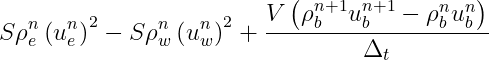

In [104]:
from sympy import * 
import numpy as np
import sympy
sympy.init_printing(use_latex='png', fontsize='12pt')
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.dpi'] = 200

rho, rho1, rho2 = symbols(r"\rho \rho_1 \rho_2")
h = symbols("h")
S,V,dt = symbols(r"S V \Delta_t") 
U0 = 1 #symbols("U_0")
Uan0,Ubn0,Ucn0,Uwn0,Uen0 = symbols("u_a^{n} u_b^{n} u_c^{n} u_w^{n} u_e^{n}")
Uan1,Ubn1,Ucn1,Uwn1,Uen1 = symbols("u_a^{n+1} u_b^{n+1} u_c^{n+1} u_w^{n+1} u_e^{n+1}")
rhoan0,rhobn0,rhocn0,rhown0,rhoen0 = symbols(r"\rho_a^{n} \rho_b^{n} \rho_c^{n} \rho_w^{n} \rho_e^{n}")
rhoan1,rhobn1,rhocn1,rhown1,rhoen1 = symbols(r"\rho_a^{n+1} \rho_b^{n+1} \rho_c^{n+1} \rho_w^{n+1} \rho_e^{n+1}")

alpha = symbols(r"\alpha")

# Momentum equation with the linearized convective term and explicit discretization.
Ueqn = (V / dt)*(rhobn1*Ubn1 - rhobn0*Ubn0) - Uwn0*S*rhown0*Uwn0 + Uen0*S*rhoen0*Uen0
Ueqn

# Solving discretized momentum equation for $U_b^{n+1}$
 
To compute the new velocity $U_b^{n+1}$, we need an explicit discretization, and we assume $\Delta_t < \Delta_t^E$, where $\Delta_t^E$ provides a stable solution. 

Using Euler-explicit or Euler-implicit makes no difference in terms of the temporal order of accuracy, and the explicit discretization allows us to express the new velocity $U_b^{n+1}$ without having to solve a linear equationi system, i.e.

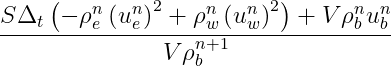

In [105]:
Ubn1Sol = solve(Ueqn, Ubn1)[0]

Ubn1Sol

# Assign a constant initial velocity and use equidistant cells

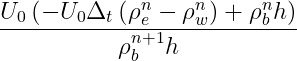

In [107]:
U0 = symbols("U0")
Ubn1SolExplicit = simplify(Ubn1Sol.subs({Uen0 : U0, Uwn0 : U0, Ubn0 : U0,  V : h**3, S : h**2}))
Ubn1SolExplicit

The new velocity still depends on the position of the interface, because the position of the interface determines the densities $\rho_b^n,\rho_b^{n+1},\rho_e^{n},\rho_w^{n}$.

## Case A : single-phase cell, all densities are equal in the new and the old time step

In [108]:
Ubn1SolExplicitA = Ubn1SolExplicit.subs({rhown0 : rho1, rhobn0 : rho1, rhobn1 : rho1, rhoen0 : rho1})
Ubn1SolExplicitA

## Case B: interface flows into the cell $[x_w, x_b]$ 

\begin{align*}
\Large
&\Large----a---|_{\Gamma^{n}}--w--b----e----c---- \\
&\Large----a-----w--|_{\Gamma^{n+1}}b----e----c----
\end{align*}

$|_\Gamma$ denotes the position of the Front $\Gamma$ at time $t$ in the cell stencil (a,b,c).

This sets the negative distance field $^-$ and positive distance field values $^+$ at $n,n+1$ as follows

\begin{align*}
\Large
&\Large----a^{-}----w^{+}----b^+----e^+----c^+---- \\
&\Large----a^{-}----w^{-}----b^+----e^+----c^+----
\end{align*}

From the signs of the signed distance function $\phi$ in the above stencil, which is for this case the same for $n,n+1$, we see that 

\begin{align}
\rho_w^{n} &= \rho_1 \\
\rho_b^{n} &= \rho_1 \\
\rho_b^{n+1} &= \alpha_b^{n+1} \rho_1 + (1 - \alpha_b^{n+1})\rho_2 \\
\rho_e^{n} = \rho_1 
\end{align}

Which we substitute into the solution for $U_b^{n+1}$

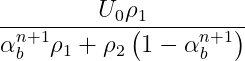

In [109]:
alphabn1 = symbols(r'\alpha_b^{n+1}')
Ubn1SolExplicitB = Ubn1SolExplicit.subs({rhown0 : rho1, rhobn0 : rho1, rhobn1 : alphabn1*rho1+(1-alphabn1)*rho2, rhoen0 : rho1})
Ubn1SolExplicitB

Using a density ratio $\frac{\rho_1}{\rho_2} = 1000$

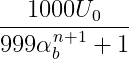

In [110]:
Ubn1SolExplicitBwaterAir = simplify(Ubn1SolExplicitB.subs({rho1 : 1000 * rho2}))
Ubn1SolExplicitBwaterAir

Dividing this velocity $U_b^{n+1}$ with $U_0$ gives the amplification factor with respect to $U_0$, that tells us how $U_0$ increases/decreases with $\alpha_b^{n+1}$. We can then plot this factor using $\alpha_b^{n+1} \in [0,1]$

          1000         
───────────────────────
999⋅\alpha_b__{n+1} + 1


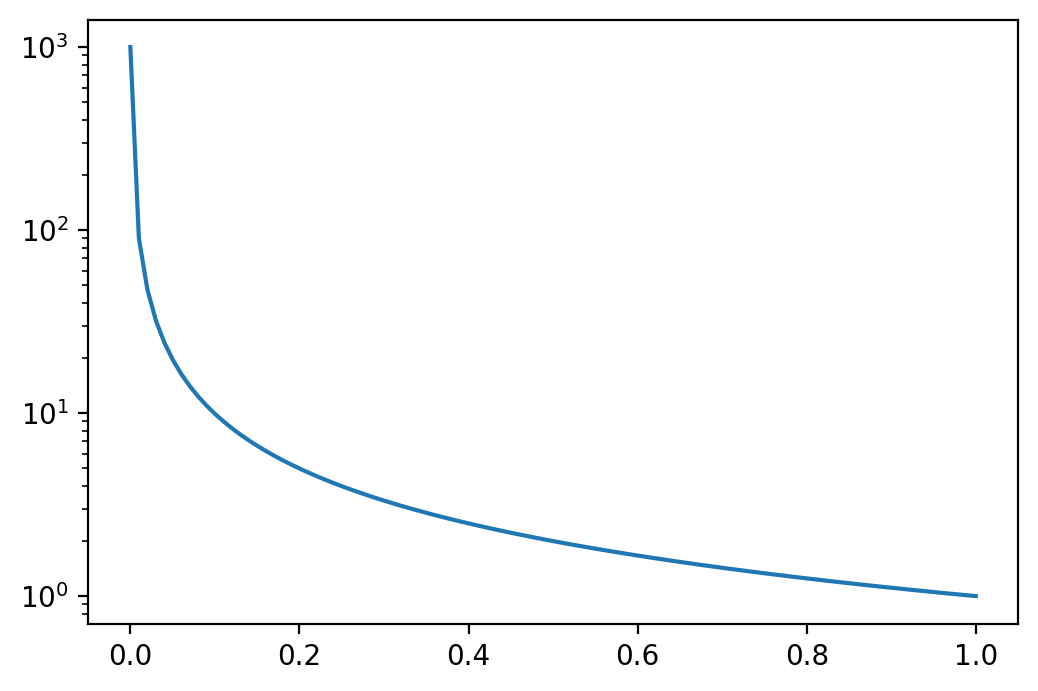

In [111]:
Ufactor = Ubn1SolExplicitBwaterAir / U0
pprint(Ufactor)
alphas = np.linspace(0,1,100)
UfactorValues = [float(Ufactor.subs({alphabn1 : alphaValue})) for alphaValue in alphas]
plt.semilogy()
plt.plot(alphas, UfactorValues)

So even with a stable explicit solution proposed by 

## Case C : interface stays in cell b 

\begin{align*}
\Large
&\Large----a-----w-|_{\Gamma^{n}}-b----e----c---- \\
&\Large----a-----w---b---|_{\Gamma^{n+1}}-e----c----
\end{align*}

$|_\Gamma$ denotes the position of the Front $\Gamma$ at time $t$ in the cell stencil (a,b,c).

This sets the negative distance field $^-$ and positive distance field values $^+$ at $n,n+1$ as follows

\begin{align*}
\Large
&\Large----a^{-}----w^{-}----b^+----e^+----c^+----\\
\end{align*}

From the signs of the signed distance function $\phi$ in the above stencil, which is for this case the same for $n,n+1$, we see that 

\begin{align}
\rho_w^{n} & = \rho_2 \\
\rho_b^{n} & = \alpha_b^n \rho_1 + (1 - \alpha_b^n) \rho_2 \\
\rho_b^{n+1} & = \alpha_b^{n+1} \rho_1 + (1 - \alpha_b^{n+1}) \rho_2 \\
\rho_e^{n} & = \rho_1 
\end{align}

Which we substitute into the solution for $U_b^{n+1}$

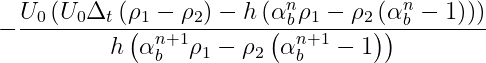

In [114]:
alphabn0 = symbols(r"\alpha_b^n")
Ubn1SolExplicitC = simplify(Ubn1SolExplicit.subs({rhown0 : rho2, rhobn0 : alphabn0 *rho1 + (1-alphabn0)*rho2, \
                                                  rhobn1 : alphabn1 *rho1 + (1-alphabn1)*rho2, rhoen0 : rho1}))
Ubn1SolExplicitC

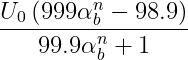

In [115]:
Ubn1SolExplicitCwaterAir = simplify(Ubn1SolExplicitC.subs({alphabn1 : 1e-01*alphabn0,rho1 : 1000 * rho2, dt*U0 : 0.1*h}))
Ubn1SolExplicitCwaterAir

999⋅\alpha_b__n - 98.9
──────────────────────
 99.9⋅\alpha_b__n + 1 


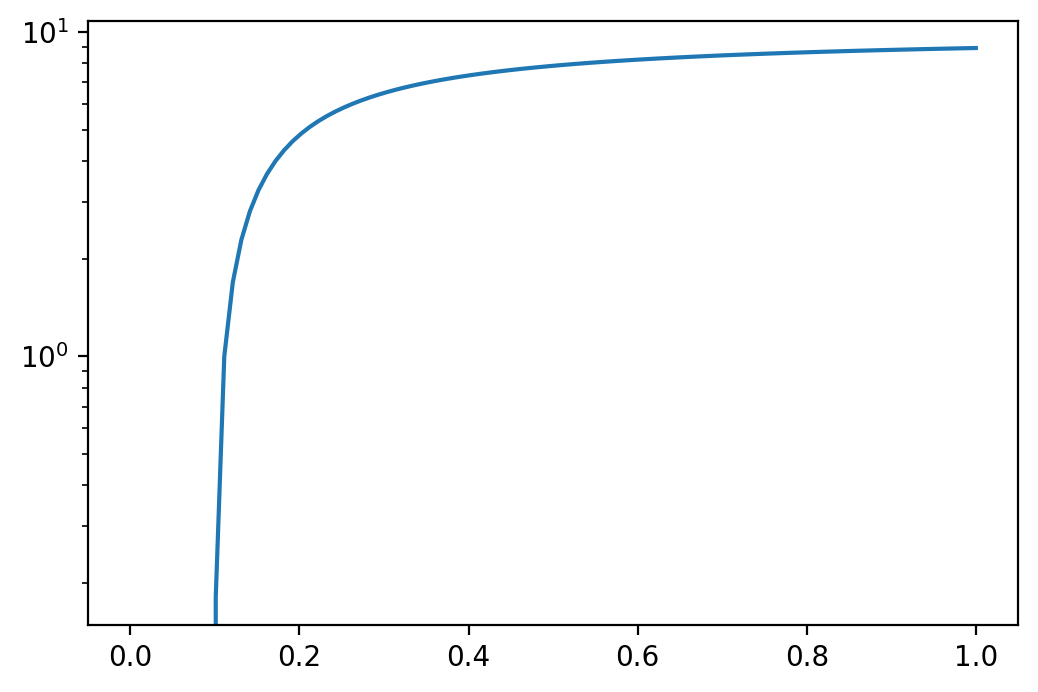

In [116]:
Ufactor = Ubn1SolExplicitCwaterAir / U0
pprint(Ufactor)
alphas = np.linspace(0,1,100)
UfactorValues = [float(Ufactor.subs({alphabn0 : alphaValue})) for alphaValue in alphas]
plt.semilogy()
plt.plot(alphas, UfactorValues)